# HW2-V2 DATASCI W261: Machine Learning at Scale 

* **Name:**  Megan Jasek
* **Email:**  meganjasek@ischool.berkeley.edu
* **Class Name:**  W261-2
* **Week Number:**  2, revision
* **Date:**  6/4/2016

**HW2 Version 2 Question:** What would happen if you use two reducers for learning a NB classifier? How would that complicate things?  

ANSWER:  If multiple reducers were used for the training of the model, then the following applies:
* The total count of documents can just passed to one of the reducers.  This is only used for the calculation of the prior probabilities and that calculation is only done once and then the priors could be written to the model output.
* The total count of words for each class would need to be sent to all reducers because when calculating the conditional probabilities for the words, it is divided by the total word counts of its class.
* Since the MapReduce framework guarantees that all instances of the same key get sent to the same reducer, the solution will still be correct if the keys are broken up over multiple reducers.  As long as the total count of words is sent to each reducer, the conditional probabilities for each term will be correct.    

One way to ensure that the count of words is sent to each reducer is to partition all of the words by prepending a label like 'a' and 'b' to each of the words.  And then prepending each label to the total count of words, so there would be an output 'a, total_word_count' and 'b, total_word_count'.  This way the total word count will be sent to the reducer that handles the 'a' keys and to the reducer that handles the 'b' keys.  If there were more than 2 reducers, more partitioning labels could be used.  As long as all of the labels are prepended to the total word counts the solution would work.


**HW2.0.**  
**HW2.0.1.** What is a race condition in the context of parallel computation? Give an example.  
ANSWER:  A race condition is a potential software bug introduced when writing parallel computer programs (programs that do more than one thing at a time).  It is when the program does two tasks at the same time when the tasks actually need to be done in a particular sequence for the solution to be correct.  

Example:  A website does a 5-minute data upload with new data every hour on the hour.  A user reads data from this website exactly 3 minutes after the hour every hour and the user expects the most up-to-date data.  This is a race condition.  Two things are being done at the same time:  writing and reading.  However, in order for the solution to be correct (that the user get the most up-to-date data), the program should finish writing the new data before it allows the user to read the data.

**HW2.0.2.** What is MapReduce?  
ANSWER:  MapReduce can refer to three distinct but related concepts:
1. MapReduce is a programming model for processing and generating large data sets with a parallel, distributed algorithm on a cluster.
2. MapReduce can refer to the execution framework that coordinates the execution of programs written in this particular style.
3. MapReduce can refer to the software implementation of the programming model and the execution framework: for example, Google's proprietary implementation vs. the open-source Hadoop implementation in Java.

**HW2.0.3.** How does it differ from Hadoop?  
ANSWER:  MapReduce is the generic term for the programming model or framework.  Hadoop (or Apache Hadoop) implements a popular open-source version of the MapReduce framework.  Other organizations have created implementations in many programming languages for the MapReduce framework with different levels of optimization.

**HW2.0.1.** Which programming paradigm is Hadoop based on? Explain and give a simple example of functional programming in raw python code and show the code running. E.g., in raw python find the average length of a string in and of strings using a python "map-reduce" (functional programming) job (similar in style to the above). Alternatively, you can do this in python Hadoop Streaming.  strings = ["str1", "string2", "w261", "MAchine learning at SCALE"]  

ANSWER:  
Average String Length: 10.000000

**HW2.0.1.1** Which programming paradigm is Hadoop based on? Explain.  
ANSWER:  Hadoop (or the MapReduce portion of it anyway) is based on functional programming.  Functional programming is a style of programming that avoids changing state and changing data.  The output of a functional program depends only on the input coming in.  There are no side effects (changes in state or data that do not depend on the inputs).  If you run a function more than once on the same inputs, then the function will produce the same outputs every time.  Hadoop is based on this programming model to facilitate parallelization of problems.  If the jobs that are being run in parallel are functional programs then it is known that no state or data is being changed.  Only the output from the program is returned.  If state and data are changed while programs are being run in parallel, this can create synchronization issues with incorrect state or data being used by some of the programs.  These synchronization issues are more complicated to solve.

In [1]:
# Set the location of the Hadoop Streaming jar
hadoopStreamingJar =  '/usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar'

In [9]:
# Create a directory in HDFS to store the data for this problem
!/usr/local/hadoop/bin/hdfs dfs -mkdir /user
!/usr/local/hadoop/bin/hdfs dfs -mkdir /user/hadoop

16/05/20 22:10:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read the strings.txt input file into HDFS
!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal strings.txt /user/hadoop

16/05/26 09:20:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW2.0.1
## This code reads the input file and writesthe length of each string for the reducer

import sys

# input comes from STDIN (standard input)
for line in sys.stdin:
    # write the length of the string for the mapper
    print('%d' % (len(line.strip())))

Overwriting mapper.py


In [3]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW2.0.1
## This code reads the lengths of strings from the mapper and sums them.
## Then it divides that sum by the count of inputs that came from the mapper
## to get an average length of the strings.

import sys

count=0
total_length = 0
# input comes from STDIN
for line in sys.stdin:
    total_length += int(line.strip())
    count += 1
average_length = total_length / float(count)
print('Average String Length: %f' % (average_length))

Overwriting reducer.py


In [4]:
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-0-1/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-0-1
# Run a Hadoop streaming job.  The input file 'strings.txt' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/strings.txt -output /user/hadoop/outputHW2-0-1

16/06/04 13:33:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:33:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-0-1/_SUCCESS
16/06/04 13:33:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-0-1/part-00000
16/06/04 13:33:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:33:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar2614560373457695083/] [] /tmp/streamjob7666007817116497229.jar tmpDir=null
16/06/04 13:33:24 INFO client.RMProxy: Connecting to ResourceManager at master/50.97

In [6]:
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-0-1
# Print the output file
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-0-1/part-00000

16/06/04 13:34:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 13:33 /user/hadoop/outputHW2-0-1/_SUCCESS
-rw-r--r--   3 hadoop supergroup         34 2016-06-04 13:33 /user/hadoop/outputHW2-0-1/part-00000
16/06/04 13:34:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Average String Length: 10.000000	


**HW2.1.** Sort in Hadoop MapReduce.  **Given as input:** Records of the form (integer, “NA”), where integer is any integer, and “NA” is just the empty string.  **Output:** sorted key value pairs of the form (integer, “NA”) in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.

**HW2.1.1.** What happens if you have multiple reducers? Do you need additional steps? Explain.  
ANSWER:  If there are multiple reducers, then there will be multiple output files - one output file for each reducer.  Even though this is the case, additional MapReduce jobs are not required for a correct solution.  The summary of the solution is as follows.  The mapper can be programmed to add a tag to the front of each of its outputs.  This will be the new key.  The tag will be the partition rule.  The tag is assigned according to how the integers should be routed to the reducers (example:  an A could be assigned for integers less than 0 and a B could be assigned for integers greater than or equal to 0.).  Then in the Hadoop shuffle phase everything with the same tag will be routed to the same reducer.  In this way, the programmer can ensure that all the integers of a certain range (example:  -infinity to 0) are routed to one reducer and all of the integers of other ranges (example:  0 to infinity) are routed to other reducers.  When the integers are routed by range in this fashion, then all of the output files from the reducers can be aggregated for each range and they will all be sorted correctly.  Once the integers are sent to the correct reducer, then in the Hadoop shuffle phase, they can be sorted by value (this would be the 2nd element of the key, value pair).  Then when they arrive at the reducer, they will already be in sorted order, so the reducer will just need to print them out.  All of the sorting can still be done in the Hadoop shuffle phase even if there are multiple reducers.

**Part 1** Write code to generate N random records of the form (integer, “NA”). Let N = 10,000.

**Part 2** Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers.  (See output below.) 


In [2]:
# Part 1.  Write code to generate N  random records of the form (integer, “NA”). Let N = 10,000.
# This code generates 10,000 numbers in the range of [-10,000, 10,000] and writes it to a file called
# "random_integers.txt".  It uses the Python library random to generate the random integers.
import random

N=10000
min_int = -100000
max_int = 100000
filename = "random_integers.txt"
with open(filename, 'w') as f:
    for i in range(N):
        f.write('<%d, "">\n' % (random.randint(min_int, max_int)))

In [10]:
# Read the random_integers.txt input file into HDFS
#!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal random_integers.txt /user/hadoop

16/05/20 22:11:08 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
drwxr-xr-x   - hadoop supergroup          0 2016-05-20 22:10 /user/hadoop/outputHW2-1
-rw-r--r--   3 hadoop supergroup     123850 2016-05-20 22:09 /user/hadoop/random_integers.txt


In [22]:
# Check to make sure the file is there.
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop

16/05/20 22:33:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 1 items
-rw-r--r--   3 hadoop supergroup     123850 2016-05-20 22:09 /user/hadoop/random_integers.txt


In [7]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: mapper code for HW2.1.
## This code reads the input file and writes each integer to STDOUT for the reducer to use.

import sys

# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove the angle brackets
    line = line.strip('<>\n')
    # split the line into words
    words = line.split(',')
    # write the results to STDOUT (standard output);
    # what we output here will be the input for the
    # Reduce step, i.e. the input for reducer.py
    print('%s' % (words[0]))

Overwriting mapper.py


In [8]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW2.1.
## This code prints out the biggest 10 and smallest 10 numbers from the input.
## The Hadoop shuffle phase already sorts the inputs, so the numbers are already sorted
## when they reach the reducer.  The reducer prints the 1st 10 numbers it encounters which
## would be the largest and the last 10 numbers it encounters which would be the smallest.

import sys

N=10000
i=0
# input comes from STDIN
for line in sys.stdin:
    if (i>=0 and i<10) or (i>=(N-10) and i<N):
        print('<%s, "">' % (line.strip()))
    i += 1

Overwriting reducer.py


In [9]:
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-1/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-1
# Run a Hadoop streaming job.  The input file 'random_integers.txt' is passed as input.
# The '-D mapred.text.key.comparator.options=-nr' means that in the Hadoop shuffle the keys will be treated as numbers (-n)
# and not strings and the sort order (-r) will be descending and not ascending.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options=-nr \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/random_integers.txt -output /user/hadoop/outputHW2-1

16/06/04 13:34:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:34:55 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-1/_SUCCESS
16/06/04 13:34:55 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-1/part-00000
16/06/04 13:34:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:34:57 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5419556954724451299/] [] /tmp/streamjob1811880082683433351.jar tmpDir=null
16/06/04 13:34:58 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.205

In [10]:
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-1
# Print the output file which contains the sorted numbers
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-1/part-00000

16/06/04 13:35:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 13:35 /user/hadoop/outputHW2-1/_SUCCESS
-rw-r--r--   3 hadoop supergroup        270 2016-06-04 13:35 /user/hadoop/outputHW2-1/part-00000
16/06/04 13:35:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
<99999, "">	
<99995, "">	
<99982, "">	
<99974, "">	
<99969, "">	
<99942, "">	
<99929, "">	
<99892, "">	
<99887, "">	
<99882, "">	
<-99775, "">	
<-99842, "">	
<-99867, "">	
<-99889, "">	
<-99912, "">	
<-99939, "">	
<-99943, "">	
<-99961, "">	
<-99984, "">	
<-99994, "">	


**HW2.2.**  WORDCOUNT.  Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.
       
ANSWER:  Word count for the word "assistance" is 10.

In [11]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 1 code for HW2.2

# Import print function from python 3
from __future__ import print_function
import sys
# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

count_vocab_terms = {}

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line by tabs and store the result in the 'items' list.
    items = line.split('\t')
    if len(items) > 1:
        # Ignore the 1st 2 values of the line, the ID and TRUTH value as they will not be counted
        # The 3rd value of the line is the subject.  Convert this value to lowercase and then
        # break it up into separate words using the WORD_RE regular expression
        words_all = re.findall(WORD_RE, items[2].lower())
        # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
        # break it up into separate words using the WORD_RE regular expression
        if len(items) == 4:
            words_all = words_all + re.findall(WORD_RE, items[3].lower())
    else:
        # This handles line 60 which is only a partial input line and contains only one item
        words_all = re.findall(WORD_RE, items[0].lower())
    # Loop through each of the terms in the words of this line and add the counts to the 
    # total word counts.
    for term in words_all:
        if term not in count_vocab_terms:
            count_vocab_terms[term] = 1
        else:
            count_vocab_terms[term] += 1
            
# Print each term in the vocab and then its count
for term in count_vocab_terms:
    print('%s\t%d' % (term, count_vocab_terms[term]))

Overwriting mapper.py


In [13]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW2.2

# Import sys library to access arguments passed in when the module is called
import sys

# Initialize a dictionary to store the term counts
count_vocab_terms = {}

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line by tabs
    items = line.split("\t")
    # The 1st value in the line is the term
    term = items[0]
    # Read the term counts from the mapper and aggregate them.
    if term not in count_vocab_terms:
        count_vocab_terms[term] = int(items[1])
    else:
        count_vocab_terms[term] += int(items[1])

# Print each term in the vocab and then its count
for term in count_vocab_terms:
    print('%s\t%d' % (term, count_vocab_terms[term]))

Overwriting reducer.py


In [14]:
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-2/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-2
# Run a Hadoop streaming job.  The input file 'enronemail_1h.txt' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/enronemail_1h.txt -output /user/hadoop/outputHW2-2

16/06/04 13:35:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:35:46 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-2/_SUCCESS
16/06/04 13:35:46 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-2/part-00000
16/06/04 13:35:47 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:35:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar144073123672936299/] [] /tmp/streamjob4167535583384888779.jar tmpDir=null
16/06/04 13:35:49 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.205.

In [16]:
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-2
# Print the output file which contains the sorted numbers
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-2/part-00000

16/05/25 23:33:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-05-25 23:33 /user/hadoop/outputHW2-2/_SUCCESS
-rw-r--r--   3 hadoop supergroup      53483 2016-05-25 23:33 /user/hadoop/outputHW2-2/part-00000
16/05/25 23:33:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
yellow	1
four	8
prefix	1
railing	1
looking	4
granting	1
electricity	1
originality	1
homemakers	1
hormone	2
regional	11
screaming	1
barraged	1
internally	2
prize	1
customizable	1
wednesday	6
cyberopps	2
charter	2
tired	2
miller	1
bacon	1
tires	3
second	4
errors	6
thunder	1
daysor	1
bonuses	4
increasing	4
duns	2
mailings	2
here	55
china	2
borrowers	1
k	4
reports	1
oxymoron	1
i'd	2
i'm	7
explained	1
lengthen	1
replace	2
brought	1
stern	1
055	2
txu	2
classifieds	1
unit	7
derivatives	3
spoke	2
dnb	

In [12]:
# Copy the model output from the 1st reducer to the local file system
#!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/outputHW2-2/part-00000 word_counts.txt
# Read the word_counts.txt input file into HDFS
#!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal word_counts.txt /user/hadoop

16/05/26 12:52:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**HW2.2.1** Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

ANSWER:  The top-10 occurring tokens are as follows:  
1. the - 1247
2. to - 963
3. and - 668
4. of - 566
5. a - 542
6. you - 432
7. in - 417
8. your - 394
9. ect - 382
10. for - 373

In [16]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 1 code for HW2.2.  Identity mapper.

import sys
for line in sys.stdin:    
    print "%s" % (line.strip())

Overwriting mapper.py


In [17]:
%%writefile reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Megan Jasek
## Description: reducer code for HW2.2.  Identity reducer that prints its first 10 inputs.

import sys
i=0
for line in sys.stdin:  
    if i < 10:
        print "%s" % (line.strip())
    else:
        break
    i += 1

Overwriting reducer.py


In [18]:
# Remove output from previous runs of this command
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-2-1/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-2-1
# Run a Hadoop streaming job.  The input file 'enronemail_1h.txt' is passed as input.
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-D stream.num.map.output.key.field=2 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keypartitioner.options=-k2,2 \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options="-k2,2nr" \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/word_counts.txt -output /user/hadoop/outputHW2-2-1

16/06/04 13:36:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:36:29 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-2-1/_SUCCESS
16/06/04 13:36:29 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-2-1/part-00000
16/06/04 13:36:30 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:36:32 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar3189511823649876900/] [] /tmp/streamjob422449474231994691.jar tmpDir=null
16/06/04 13:36:32 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.

In [24]:
# Print out what files were created from the MapReduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-2-1
# Print the output file which contains the sorted numbers
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-2-1/part-00000

16/05/26 12:57:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-05-26 12:57 /user/hadoop/outputHW2-2-1/_SUCCESS
-rw-r--r--   3 hadoop supergroup         77 2016-05-26 12:57 /user/hadoop/outputHW2-2-1/part-00000
16/05/26 12:57:24 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
the	1247
to	963
and	668
of	566
a	542
you	432
in	417
your	394
ect	382
for	373


**HW2.3.** Multinomial NAIVE BAYES with NO Smoothing.  Using the Enron data from HW1 and Hadoop MapReduce, write a mapper/reducer job(s) that will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters).  NOTE: please assume one reducer.

**HW2.3.1.** Count up how many times you need to process a zero probabilty for each class and report.  
ANSWER:  
Number of zero probabilities for Ham class:  5617  
Number of zero probabilities for Spam class:  4960  

**HW2.3.2.** Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier.  
ANSWER:  Training Error for HW2.3: 0% (0/100 documents misclassified)

**HW2.3.3.** Plot a histogram of the posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see.  
ANSWER:  (See histograms below.)  Histograms for both the posterior probabilites and log posterior probabilities (called scores for the rest of this problem) were plotted.  The probability histograms suffer from floating-point underflow and will not be used.  For the scores histograms, the spam scores for the ham documents were assigned a very large negative number by the model.  (And also the ham scores for the spam documents were assigned a very large negative number.)  This number has been adjusted to -30,000 so that the values display in a more readable way in the histogram.  

The ham scores histogram shows the 44 documents that are classified as spam at the -30,000 frequency.  For the rest of the documents (the ham documents), there is a negatively skewed distribution with values accumulating just below 0.  The range of the values is from -9711.807285 to -29.483180.  The average value is -1682.705902.  The median value is -1094.666381.

The spam scores histogram shows the 56 documents that are classified as spam at the -30,000 frequency.  For the rest of the documents (the spam documents), there is a negatively skewed distribution with values accumulating just below 0.  The range of the values is from -28415.476872 to -55.316830.  The average value is -2838.403308.  The median value is -975.516131.

As the score gets more and more negative (further from 0) it means that there are more words in that document in general or more words in that document that are contributing to the classification of the document.  For the spam class there are a few more outlier words that have large negative values than the ham class.  The average score for spam is lower than for ham.  This could mean that in general either spam documents are longer than ham documents or more words are used to classify documents as spam than as ham.

[-30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -9711.807285, -6330.956431, -5683.511342, -5027.774416, -4183.541952, -3656.550806, -3628.592339, -3207.512239, -3033.157012, -2906.357969, -2754.069037, -2750.998601, -2740.222547, -2694.596537, -1908.42553, -1783.952568, -1753.450314, -1652.851395, -1520.983979, -1444.307516, -1379.201515, -1364.741873, -1328.429372, -1266.125083, -1244.284239, -1180.553382, -1176.968494, -1102.79263, -1086.540133, -1085.933136, -988.159991, -983.248804, -910.184001, -894.568932, -829.093564, -777.59393, -740.821221, -689.5157, -681.002141, -678.138612, -662.30242, -589.805873, -492.008252, -489.604258, -445.866953, -438.336438, -425.885545, -412.100803,

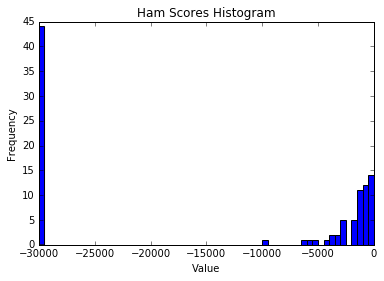

[-30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000, -28415.476872, -16821.891197, -15962.696793, -7662.008571, -5938.923501, -4433.339528, -3610.868416, -3488.565338, -3456.055866, -3327.999987, -2645.34503, -2372.297577, -1516.883469, -1496.171699, -1478.182135, -1296.9463, -1293.093393, -1274.550319, -1272.033171, -1149.101126, -1063.366585, -1018.973163, -932.059099, -932.059099, -921.727375, -894.550862, -894.550862, -851.89197, -843.304476, -818.62467, -800.858948, -799.577775, -783.235519, -778.902558, -676.86741, -659.5266, -606.53935, -525.924462, -387.054605, -211.571639, -189.339428, -1

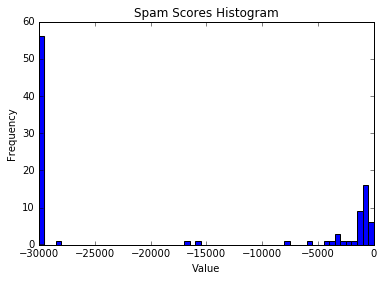

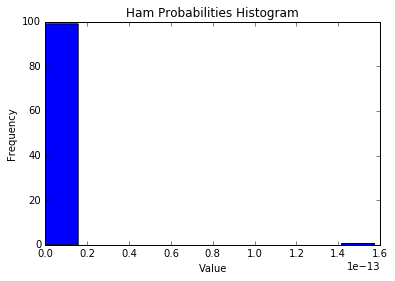

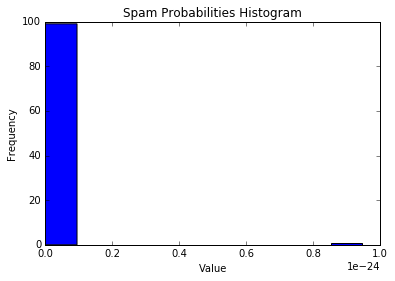

In [9]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# PART 2.3.3. Plot a histogram of the posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set.
import matplotlib.pyplot as plt
import numpy as np
import math

# Create lists to store the ham and spam scores and probabilities.  The scores are the sums of the
# log probabilities
doc_scores_ham = []
doc_scores_spam = []
doc_probs_ham = []
doc_probs_spam = []
# Read the data from the doc_scores.txt file that was saved after the HW2.3 predictions were made using
# Hadoop streaming.
with open("doc_scores.txt", 'r') as f:
    for line in f.readlines():
        items = line.split('\t')
        if len(items) == 4:
            ID = items[0]
            TRUTH = int(items[1])
            # Extract the score data and store it in the doc_scores_ham and doc_scores_spam lists
            ham_score = float(items[2])
            spam_score = float(items[3])
            if ham_score <= -1000000000:
                ham_score = -30000
            if spam_score <= -1000000000:
                spam_score = -30000
            doc_scores_ham.append(ham_score)
            doc_scores_spam.append(spam_score)
            # Extract the score data and store it in the doc_scores_ham and doc_scores_spam lists
            ham_prob = math.exp(float(items[2]))
            spam_prob = math.exp(float(items[3]))
            doc_probs_ham.append(ham_prob)
            doc_probs_spam.append(spam_prob)

import numpy as np

# Plot the Ham Scores Histogram
print(sorted(doc_scores_ham))
print('\n')
print('Range of ham values: %f to %f' % (-9711.807285, max(doc_scores_ham)))
l = [-9711.807285, -6330.956431, -5683.511342, -5027.774416, -4183.541952, -3656.550806, -3628.592339, -3207.512239, 
              -3033.157012, -2906.357969, -2754.069037, -2750.998601, -2740.222547, -2694.596537, -1908.42553, -1783.952568,
              -1753.450314, -1652.851395, -1520.983979, -1444.307516, -1379.201515, -1364.741873, -1328.429372, -1266.125083, 
              -1244.284239, -1180.553382, -1176.968494, -1102.79263, -1086.540133, -1085.933136, -988.159991, -983.248804, 
              -910.184001, -894.568932, -829.093564, -777.59393, -740.821221, -689.5157, -681.002141, -678.138612, -662.30242, 
              -589.805873, -492.008252, -489.604258, -445.866953, -438.336438, -425.885545, -412.100803, -380.540486, -336.646947, 
              -301.633045, -201.084174, -141.73486, -78.266071, -44.714622, -29.48318]
print('Average Ham: %f, Median Ham: %f' % (np.mean(l), np.median(l)))
binwidth = 500
plt.hist(doc_scores_ham, bins=np.arange(min(doc_scores_ham), max(doc_scores_ham) + binwidth, binwidth))
plt.title("Ham Scores Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Plot the Spam Scores Histogram
print(sorted(doc_scores_spam))
print('\n')
print('Range of spam values: %f to %f' % (-28415.476872, max(doc_scores_spam)))
l = [-28415.476872, -16821.891197, -15962.696793, -7662.008571, -5938.923501, -4433.339528, -3610.868416, -3488.565338, 
     -3456.055866, -3327.999987, -2645.34503, -2372.297577, -1516.883469, -1496.171699, -1478.182135, -1296.9463, 
     -1293.093393, -1274.550319, -1272.033171, -1149.101126, -1063.366585, -1018.973163, -932.059099, -932.059099, -921.727375,
     -894.550862, -894.550862, -851.89197, -843.304476, -818.62467, -800.858948, -799.577775, -783.235519, -778.902558, -676.86741, 
     -659.5266, -606.53935, -525.924462, -387.054605, -211.571639, -189.339428, -174.019524, -157.472449, -55.31683]
print('Average Spam: %f, Median Spam: %f' % (np.mean(l), np.median(l)))
binwidth = 500
plt.hist(doc_scores_spam, bins=np.arange(min(doc_scores_spam), max(doc_scores_spam) + binwidth, binwidth))
plt.title("Spam Scores Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Plot the Ham Probabilities Histogram
plt.hist(doc_probs_ham)
plt.title("Ham Probabilities Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Plot the Spam Probabilities Histogram
plt.hist(doc_probs_spam)
plt.title("Spam Probabilities Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [51]:
# Read the input file into HDFS
#!/usr/local/hadoop/bin/hdfs dfs -copyFromLocal enronemail_1h.txt /user/hadoop
# Check to make sure the file is there
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop

16/05/21 14:24:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
-rw-r--r--   3 hadoop supergroup     203981 2016-05-21 14:24 /user/hadoop/enronemail_1h.txt
drwxr-xr-x   - hadoop supergroup          0 2016-05-21 14:06 /user/hadoop/outputHW2-1
-rw-r--r--   3 hadoop supergroup     123850 2016-05-20 22:09 /user/hadoop/random_integers.txt


In [19]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 1 code for HW2.3

# Import print function from python 3
from __future__ import print_function
import sys
# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

# Initialize counts.  All of the variables are lists storing 2 counts.  The 1st count
# in the list is the count for class 0 which is Ham and the 2nd count is the count
# for class 1 which is Spam.
# Variable count_docs:  stores the total number of documents for each class.
# Variable count_words:  stores the total number of words in the subject and body fields
# for each class.
# Variable count_vocab_terms:  stores the total number of occurances of the words in the 
# vocab that is being used for classification in each of the classes.
# Variable vocab:  stores the unique terms used in this file
count_docs = [0, 0]
count_words = [0, 0]
count_vocab_terms = {}
vocab = []

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line tabs and store the result in the 'items' list.
    items = line.split('\t')
    # This bypasses line 60 which is only a partial input line, so it is ignored
    if len(items) == 1:
        continue
    # The 1st value of the line is the ID of the document
    ID = items[0]
    # The 2nd value of the line is the true classification of the document called: TRUTH
    TRUTH = int(items[1])
    # The 3rd value of the line is the subject.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    words_all = re.findall(WORD_RE, items[2].lower())
    # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    if len(items) == 4:
        words_all = words_all + re.findall(WORD_RE, items[3].lower())
    # Update 'count_docs' by 1 for the class of this document
    count_docs[TRUTH] += 1
    # Update 'count_words' by the length of the 'words_all' list for the class of this document
    count_words[TRUTH] += len(words_all)
    # Create a variable to store the unique words from this line.
    vocab_line = []
    # Loop through each of the terms in the words of this line
    for term in words_all:
        # Update the vocab for this file
        if term not in vocab:
            vocab.append(term)
        # Update the vocab for this line
        if term not in vocab_line:
            vocab_line.append(term)
        # Initialize a list to store the count of this term
        if term not in count_vocab_terms:
            count_vocab_terms[term] = [0,0]
    # For each of the words in the vocabulary print out the 'term' and the '# of occurances
    # of the term' for reducer.py
    for term in vocab_line:
        # Store the number of occurances of the vocab word in the document
        count_term = words_all.count(term)
        # Update 'count_vocab_terms' for the class of this document
        count_vocab_terms[term][TRUTH] += count_term

# Print the count totals for each class that get passed to reducer.py
# Print the document count from this part of the file for Ham and Spam
print('count,docs\t%d\t%d' % (count_docs[0], count_docs[1]))
# Print the word count from this part of the file for Ham and Spam
print('count,words\t%d\t%d' % (count_words[0], count_words[1]))
# Print each term in the vocab and then its count for Ham and Spam
for term in vocab:
    print('%s\t%d\t%d' % (term, count_vocab_terms[term][0], count_vocab_terms[term][1]))

Overwriting mapper.py


In [20]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Megan Jasek
## Description: Reducer 1 code for HW2.3

# Import sys library to access arguments passed in when the module is called
import sys
# Import the math library in order to use the 'log' method to take logorithms
import math

# Initialize counts.  All of the variables are lists storing 2 counts.  The 1st count
# in the list is the count for class 0 which is Ham and the 2nd count is the count
# for class 1 which is Spam.
# Variable count_docs:  stores the total number of documents for each class.
# Variable count_words:  stores the total number of words in the subject and body fields
# for each class.
# Variable count_vocab_terms:  stores the total number of occurances of the each of the 
# words in the vocab that is being used for classification in each of the classes.
count_docs = [0, 0]
count_words = [0, 0]
count_vocab_terms = {}

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line by tabs
    elements = line.split("\t")
    # The 1st value in the line is the ID of the document
    label = elements[0]
    # Update the 'count_docs' variable with the numbers from the file for each class
    if label == 'count,docs':
        count_docs[0] += int(elements[1])
        count_docs[1] += int(elements[2])
    # Update the 'count_words' variable with the numbers from the file for each class
    elif label == 'count,words':
        count_words[0] += int(elements[1])
        count_words[1] += int(elements[2])
    # Update the 'count_vocab_terms' variable with the numbers from the file for each class
    else:
        term = label
        if term not in count_vocab_terms:
            count_vocab_terms[term] = [int(elements[1]), int(elements[2])]
        else:
            count_vocab_terms[term][0] += int(elements[1])
            count_vocab_terms[term][1] += int(elements[2])

# Create a list to store the 2 classes in this problem:  0 for Ham and 1 for Spam.
classes = [0, 1]
# Calculate the total number of documents by adding the total counts from each class.
total_docs = sum(count_docs)
# Initialize the 'prior' varialbe to store the prior probability for each class.
prior = [0, 0]
# Initialize the 'condprob' varialbe to store the conditional probilitity of each of the
# terms in the vocab each class.
condprob = {}
for term in count_vocab_terms:
    condprob[term] = [0, 0]

# Train the MultinomialNB classifer using the algorithm in the book: An Introduction to Information Retrieval
# By Christopher D. Manning, Prabhakar Raghavan & Hinrich Schutzepage page 260, Figure 13.2.
# For each of the classes:
# 1. Calculate the prior probability (prior) by dividing the total # of documents in that class by the total # of documents.
# 2. Calculate the conditional probability (condprob) for each term in the vocab by dividing the
# total # of that term in that class by the total number of terms in all documents in that class
# Use smoothing by adding 1.0 to the numerator and the denominator in the condprob equation.
# Create a variable to control if smoothing is used.
SMOOTHING = False
# Print the prior probabilities for each class
for cls in classes:
    prior[cls] = count_docs[cls] / float(total_docs)
print('prior,prob\t%f\t%f' % (prior[0], prior[1]))

# Print the conditional probabilities for each term for Ham and Spam
for term in count_vocab_terms:
    for cls in classes:
        # If using smoothing, then add 1.0 to the numerator and the denominator in the condprob equation.
        if SMOOTHING:
            condprob[term][cls] = (count_vocab_terms[term][cls]+1.0) / (float(count_words[cls])+1.0)
        # If NOT using smoothing, then leave the numerator and the denominator alone.
        else:
            condprob[term][cls] = (count_vocab_terms[term][cls]) / (float(count_words[cls]))
    print('%s\t%f\t%f' % (term, condprob[term][0], condprob[term][1]))

Overwriting reducer.py


In [21]:
# Remove output from previous mapreduce jobs
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-3a/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-3a
# Run a hadoop streaming job to create the model
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/enronemail_1h.txt -output /user/hadoop/outputHW2-3a

16/06/04 13:37:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:37:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-3a/_SUCCESS
16/06/04 13:37:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-3a/part-00000
16/06/04 13:37:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:37:24 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar8250329680862140496/] [] /tmp/streamjob745885037887334678.jar tmpDir=null
16/06/04 13:37:24 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.20

In [34]:
# Reivew the output files obtained from the above job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-3a
# Look at the contents of the output of the reducer in the part-00000 file in HDFS
#!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-3a/part-00000

16/05/26 13:40:08 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-05-25 11:35 /user/hadoop/outputHW2-3a/_SUCCESS
-rw-r--r--   3 hadoop supergroup     140783 2016-05-25 11:35 /user/hadoop/outputHW2-3a/part-00000


In [3]:
# Copy the model output from the 1st reducer to the local file system
!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/outputHW2-3a/part-00000 model.txt

16/05/21 23:29:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/21 23:29:10 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [22]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 2 code for HW2.3

# Import print function from python 3
from __future__ import print_function
import sys
# Import the math library in order to use the 'log' method to take logorithms
import math
# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

# Create a list to store the 2 classes in this problem:  0 for Ham and 1 for Spam.
classes = [0, 1]
# Initialize the 'condprob' variable to store the conditional probilitity of each of the
# terms in the vocab each class.
condprob = {}

# Load the model from the model.txt file.
# 1.  prior:  stores the prior probabilites for Ham (0) and Spam (0)
# 2.  condprob:  stores the conditional probabilities for each term for Ham (0) and Spam (0)
with open("model.txt", 'r') as f:
    for line in f.readlines():
        elements = line.split('\t')
        if elements[0] == 'prior,prob':
            prior = [float(elements[1]), float(elements[2])]
        else:
            term = elements[0]
            condprob[term] = [float(elements[1]), float(elements[2])]

# Initialize a list to store the # of times a zero probability is processed for each class
count_docs_zero_prob = [0, 0]

for line in sys.stdin:
    # Read in the lines from the input file
    # Split the line tabs and store the result in the 'items' list.
    items = line.split('\t')
    # This bypasses line 60 which is only a partial input line, so it is ignored
    if len(items) == 1:
        continue
    # The 1st value of the line is the ID of the document
    ID = items[0]
    # The 2nd value of the line is the true classification of the document called: TRUTH
    TRUTH = int(items[1])
    # The 3rd value of the line is the subject.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    words_all = re.findall(WORD_RE, items[2].lower())
    # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    if len(items) == 4:
        words_all = words_all + re.findall(WORD_RE, items[3].lower())
    # Make a prediction for each document based on the model
    score = [0, 0]
    for cls in classes:
        # Initialize the score with the prior probability for the class
        score[cls] = math.log(prior[cls])
        for term in words_all:
            # Add the conditional probability to the scoare for each term.
            # If any of the conditional probabilities for the document are 0, then set the score
            # to -100000000 because, in actuality the probabilities are being multiplied, so if one is 0
            # then the whole score will be 0.  If this happens, set the score to a very low number so that
            # this class will have a very low score and won't be selected and break out of the loop
            if condprob[term][cls] == 0.0:
                score[cls] = -1000000000
                count_docs_zero_prob[cls] += 1
            else:
                score[cls] += math.log(condprob[term][cls])
    # Set the prediction for the document to the class that has the highest score
    prediction = 1 if (score[1] > score[0]) else 0
    # Print the document ID, the real classification, the predicted classification and the score
    # for each class for the reducer
    print("%s\t%d\t%d\t%f\t%f" % (ID, TRUTH, prediction, score[0], score[1]))

# Print the number of times a zero probability for reporting purposes.
print('count,zeroprob\t%d\t%d' % (count_docs_zero_prob[0], count_docs_zero_prob[1]))

Overwriting mapper.py


In [23]:
%%writefile reducer.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: Reducer 2 code for HW2.3

import sys

# Initialize a list to store the # of times a zero probability is processed for each class
count_docs_zero_prob = [0, 0]
# Initialize variables to track the total incorrect predictions and the total predictions
count_total = 0
count_incorrect = 0
# Initialize a dictionary to store the IDs and the scores from the predictions
doc_probs = {}

# Input comes from STDIN
for line in sys.stdin:
    # Split the line by tabs
    items = line.split('\t')
    # Store the zero probability counts
    if items[0] == 'count,zeroprob':
        count_docs_zero_prob[0] += int(items[1])
        count_docs_zero_prob[1] += int(items[2])
    # Update the incorrect and total counts based on the accuracy of the prediction
    # Store the scores for each class in the doc_probs dictionary for reporting purposes
    else:
        ID = items[0]
        TRUTH = int(items[1])
        prediction = int(items[2])
        if TRUTH != prediction:
            count_incorrect += 1
        count_total += 1
        doc_probs[ID] = [TRUTH, float(items[3]), float(items[4])]

# Print the Training Error, zero probability counts and scores for reporting purposes
print('Training Error:\t%f' % (count_incorrect / float(count_total)))
print('count,zeroprob\t%d\t%d' % (count_docs_zero_prob[0], count_docs_zero_prob[1]))
for ID, probs in doc_probs.iteritems():
    print('%s\t%d\t%f\t%f' % (ID, probs[0], probs[1], probs[2]))

Overwriting reducer.py


In [24]:
# Remove the outputs from previous mapreduce jobs
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-3b/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-3b
# Call a hadoop streaming job to classify the documents.  Pass in the model.txt file so it is available
# to all of the mappers
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py,model.txt -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/enronemail_1h.txt -output /user/hadoop/outputHW2-3b

16/06/04 13:38:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:38:30 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-3b/_SUCCESS
16/06/04 13:38:30 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-3b/part-00000
16/06/04 13:38:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:38:32 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5581183124064829843/] [] /tmp/streamjob2808169144689199887.jar tmpDir=null
16/06/04 13:38:33 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [25]:
# Inspect the output produced from the mapreduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-3b
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-3b/part-00000

16/06/04 13:38:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 13:38 /user/hadoop/outputHW2-3b/_SUCCESS
-rw-r--r--   3 hadoop supergroup       5673 2016-06-04 13:38 /user/hadoop/outputHW2-3b/part-00000
16/06/04 13:38:57 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Training Error:	0.000000
count,zeroprob	5617	4960
0010.2003-12-18.GP	1	-1000000008.866751	-55.316830
0010.2001-06-28.SA_and_HP	1	-1000000000.000000	-3456.055866
0001.2000-01-17.beck	0	-3628.592339	-1000000000.000000
0018.1999-12-14.kaminski	0	-988.159991	-1000000000.000000
0005.1999-12-12.kaminski	0	-777.593930	-1000000000.000000
0011.2001-06-29.SA_and_HP	1	-1000000005.372825	-15962.696793
0008.2004-08-01.BG	1	-1000000000.000000	-5938.923501
0009.1999-12-14.farmer	0	-589.805873	-1000000000.0

In [15]:
# Copy the model output from the 2nd reducer to the local file system for reporting purposes.
!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/outputHW2-3b/part-00000 doc_scores.txt

16/05/24 23:36:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 23:36:51 WARN hdfs.DFSClient: DFSInputStream has been closed already


**HW2.4** Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

ANSWER:  
Training Error for HW2.3: 0% (0/100 documents misclassified)  
Training Error for HW2.4: 0% (0/100 documents misclassified)

Using Laplace plus-one smoothing causes no difference in the training error rate.  Smoothing does not change any results in this case because there are no term-class combinations that did not occur in the training data.  Smoothing only makes a difference when there is a new term-class combination that would have been 0 in the training data had we not added 1 to it.

In [26]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 1 code for HW2.4

# Import print function from python 3
from __future__ import print_function
import sys
# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

# Initialize counts.  All of the variables are lists storing 2 counts.  The 1st count
# in the list is the count for class 0 which is Ham and the 2nd count is the count
# for class 1 which is Spam.
# Variable count_docs:  stores the total number of documents for each class.
# Variable count_words:  stores the total number of words in the subject and body fields
# for each class.
# Variable count_vocab_terms:  stores the total number of occurances of the words in the 
# vocab that is being used for classification in each of the classes.
# Variable vocab:  stores the unique terms used in this file
count_docs = [0, 0]
count_words = [0, 0]
count_vocab_terms = {}
vocab = []

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line tabs and store the result in the 'items' list.
    items = line.split('\t')
    # This bypasses line 60 which is only a partial input line, so it is ignored
    if len(items) == 1:
        continue
    # The 1st value of the line is the ID of the document
    ID = items[0]
    # The 2nd value of the line is the true classification of the document called: TRUTH
    TRUTH = int(items[1])
    # The 3rd value of the line is the subject.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    words_all = re.findall(WORD_RE, items[2].lower())
    # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    if len(items) == 4:
        words_all = words_all + re.findall(WORD_RE, items[3].lower())
    # Update 'count_docs' by 1 for the class of this document
    count_docs[TRUTH] += 1
    # Update 'count_words' by the length of the 'words_all' list for the class of this document
    count_words[TRUTH] += len(words_all)
    # Create a variable to store the unique words from this line.
    vocab_line = []
    # Loop through each of the terms in the words of this line
    for term in words_all:
        # Update the vocab for this file
        if term not in vocab:
            vocab.append(term)
        # Update the vocab for this line
        if term not in vocab_line:
            vocab_line.append(term)
        # Initialize a list to store the count of this term
        if term not in count_vocab_terms:
            count_vocab_terms[term] = [0,0]
    # For each of the words in the vocabulary print out the 'term' and the '# of occurances
    # of the term' for reducer.py
    for term in vocab_line:
        # Store the number of occurances of the vocab word in the document
        count_term = words_all.count(term)
        # Update 'count_vocab_terms' for the class of this document
        count_vocab_terms[term][TRUTH] += count_term

# Print the count totals for each class that get passed to reducer.py
# Print the document count from this part of the file for Ham and Spam
print('count,docs\t%d\t%d' % (count_docs[0], count_docs[1]))
# Print the word count from this part of the file for Ham and Spam
print('count,words\t%d\t%d' % (count_words[0], count_words[1]))
# Print each term in the vocab and then its count for Ham and Spam
for term in vocab:
    print('%s\t%d\t%d' % (term, count_vocab_terms[term][0], count_vocab_terms[term][1]))

Overwriting mapper.py


In [27]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Megan Jasek
## Description: Reducer 1 code for HW2.4

# Import sys library to access arguments passed in when the module is called
import sys
# Import the math library in order to use the 'log' method to take logorithms
import math

# Initialize counts.  All of the variables are lists storing 2 counts.  The 1st count
# in the list is the count for class 0 which is Ham and the 2nd count is the count
# for class 1 which is Spam.
# Variable count_docs:  stores the total number of documents for each class.
# Variable count_words:  stores the total number of words in the subject and body fields
# for each class.
# Variable count_vocab_terms:  stores the total number of occurances of the each of the 
# words in the vocab that is being used for classification in each of the classes.
count_docs = [0, 0]
count_words = [0, 0]
count_vocab_terms = {}

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line by tabs
    elements = line.split("\t")
    # The 1st value in the line is the ID of the document
    label = elements[0]
    # Update the 'count_docs' variable with the numbers from the file for each class
    if label == 'count,docs':
        count_docs[0] += int(elements[1])
        count_docs[1] += int(elements[2])
    # Update the 'count_words' variable with the numbers from the file for each class
    elif label == 'count,words':
        count_words[0] += int(elements[1])
        count_words[1] += int(elements[2])
    # Update the 'count_vocab_terms' variable with the numbers from the file for each class
    else:
        term = label
        if term not in count_vocab_terms:
            count_vocab_terms[term] = [int(elements[1]), int(elements[2])]
        else:
            count_vocab_terms[term][0] += int(elements[1])
            count_vocab_terms[term][1] += int(elements[2])

# Create a list to store the 2 classes in this problem:  0 for Ham and 1 for Spam.
classes = [0, 1]
# Calculate the total number of documents by adding the total counts from each class.
total_docs = sum(count_docs)
# Initialize the 'prior' varialbe to store the prior probability for each class.
prior = [0, 0]
# Initialize the 'condprob' varialbe to store the conditional probilitity of each of the
# terms in the vocab each class.
condprob = {}
for term in count_vocab_terms:
    condprob[term] = [0, 0]

# Train the MultinomialNB classifer using the algorithm in the book: An Introduction to Information Retrieval
# By Christopher D. Manning, Prabhakar Raghavan & Hinrich Schutzepage page 260, Figure 13.2.
# For each of the classes:
# 1. Calculate the prior probability (prior) by dividing the total # of documents in that class by the total # of documents.
# 2. Calculate the conditional probability (condprob) for each term in the vocab by dividing the
# total # of that term in that class by the total number of terms in all documents in that class
# Use smoothing by adding 1.0 to the numerator and the denominator in the condprob equation.
# Create a variable to control if smoothing is used.
# For 2.4 set SMOOTHING to True
SMOOTHING = True
# Print the prior probabilities for each class
for cls in classes:
    prior[cls] = count_docs[cls] / float(total_docs)
print('prior,prob\t%f\t%f' % (prior[0], prior[1]))

# Print the conditional probabilities for each term for Ham and Spam
for term in count_vocab_terms:
    for cls in classes:
        # If using smoothing, then add 1.0 to the numerator and the denominator in the condprob equation.
        if SMOOTHING:
            condprob[term][cls] = (count_vocab_terms[term][cls]+1.0) / (float(count_words[cls])+1.0)
        # If NOT using smoothing, then leave the numerator and the denominator alone.
        else:
            condprob[term][cls] = (count_vocab_terms[term][cls]) / (float(count_words[cls]))
    print('%s\t%f\t%f' % (term, condprob[term][0], condprob[term][1]))

Overwriting reducer.py


In [28]:
# Remove output from previous mapreduce jobs
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-4a/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-4a
# Run a hadoop streaming job to create the model
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/enronemail_1h.txt -output /user/hadoop/outputHW2-4a

16/06/04 13:39:24 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:39:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-4a/_SUCCESS
16/06/04 13:39:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-4a/part-00000
16/06/04 13:39:26 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:39:27 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar8044779600659825015/] [] /tmp/streamjob1113455125883362075.jar tmpDir=null
16/06/04 13:39:28 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [33]:
# Reivew the output files obtained from the above job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-4a
# Look at the contents of the output of the reducer in the part-00000 file in HDFS
#!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-4a/part-00000

16/05/26 13:39:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-05-24 16:40 /user/hadoop/outputHW2-4a/_SUCCESS
-rw-r--r--   3 hadoop supergroup     140783 2016-05-24 16:40 /user/hadoop/outputHW2-4a/part-00000


In [33]:
# Copy the model output from the 1st reducer to the local file system
!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/outputHW2-4a/part-00000 model24.txt

16/05/24 16:40:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 16:40:43 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [29]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 2 code for HW2.4

# Import print function from python 3
from __future__ import print_function
import sys
# Import the math library in order to use the 'log' method to take logorithms
import math
# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

# Create a list to store the 2 classes in this problem:  0 for Ham and 1 for Spam.
classes = [0, 1]
# Initialize the 'condprob' variable to store the conditional probilitity of each of the
# terms in the vocab each class.
condprob = {}

# Load the model from the model.txt file.
# 1.  prior:  stores the prior probabilites for Ham (0) and Spam (0)
# 2.  condprob:  stores the conditional probabilities for each term for Ham (0) and Spam (0)
with open("model24.txt", 'r') as f:
    for line in f.readlines():
        elements = line.split('\t')
        if elements[0] == 'prior,prob':
            prior = [float(elements[1]), float(elements[2])]
        else:
            term = elements[0]
            condprob[term] = [float(elements[1]), float(elements[2])]

# Initialize a list to store the # of times a zero probability is processed for each class
count_docs_zero_prob = [0, 0]

for line in sys.stdin:
    # Read in the lines from the input file
    # Split the line tabs and store the result in the 'items' list.
    items = line.split('\t')
    # This bypasses line 60 which is only a partial input line, so it is ignored
    if len(items) == 1:
        continue
    # The 1st value of the line is the ID of the document
    ID = items[0]
    # The 2nd value of the line is the true classification of the document called: TRUTH
    TRUTH = int(items[1])
    # The 3rd value of the line is the subject.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    words_all = re.findall(WORD_RE, items[2].lower())
    # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    if len(items) == 4:
        words_all = words_all + re.findall(WORD_RE, items[3].lower())
    # Make a prediction for each document based on the model
    score = [0, 0]
    for cls in classes:
        # Initialize the score with the prior probability for the class
        score[cls] = math.log(prior[cls])
        for term in words_all:
            # Add the conditional probability to the scoare for each term.
            # If any of the conditional probabilities for the document are 0, then set the score
            # to -100000000 because, in actuality the probabilities are being multiplied, so if one is 0
            # then the whole score will be 0.  If this happens, set the score to a very low number so that
            # this class will have a very low score and won't be selected and break out of the loop
            if condprob[term][cls] == 0.0:
                score[cls] = -1000000000
                count_docs_zero_prob[cls] += 1
            else:
                score[cls] += math.log(condprob[term][cls])
    # Set the prediction for the document to the class that has the highest score
    prediction = 1 if (score[1] > score[0]) else 0
    # Print the document ID, the real classification, the predicted classification and the score
    # for each class for the reducer
    print("%s\t%d\t%d\t%f\t%f" % (ID, TRUTH, prediction, score[0], score[1]))

# Print the number of times a zero probability for reporting purposes.
print('count,zeroprob\t%d\t%d' % (count_docs_zero_prob[0], count_docs_zero_prob[1]))

Overwriting mapper.py


In [30]:
%%writefile reducer.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: Reducer 2 code for HW2.4

import sys

# Initialize a list to store the # of times a zero probability is processed for each class
count_docs_zero_prob = [0, 0]
# Initialize variables to track the total incorrect predictions and the total predictions
count_total = 0
count_incorrect = 0
# Initialize a dictionary to store the IDs and the scores from the predictions
doc_probs = {}

# Input comes from STDIN
for line in sys.stdin:
    # Split the line by tabs
    items = line.split('\t')
    # Store the zero probability counts
    if items[0] == 'count,zeroprob':
        count_docs_zero_prob[0] += int(items[1])
        count_docs_zero_prob[1] += int(items[2])
    # Update the incorrect and total counts based on the accuracy of the prediction
    # Store the scores for each class in the doc_probs dictionary for reporting purposes
    else:
        ID = items[0]
        TRUTH = int(items[1])
        prediction = int(items[2])
        if TRUTH != prediction:
            count_incorrect += 1
        count_total += 1
        doc_probs[ID] = [float(items[3]), float(items[4])]

# Print the Training Error, zero probability counts and scores for reporting purposes
print('Training Error: %f' % (count_incorrect / float(count_total)))
print('count,zeroprob\t%d\t%d' % (count_docs_zero_prob[0], count_docs_zero_prob[1]))
for ID, probs in doc_probs.iteritems():
    print('%s\t%f\t%f' % (ID, probs[0], probs[1]))

Overwriting reducer.py


In [31]:
# Remove the outputs from previous mapreduce jobs
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-4b/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-4b
# Call a hadoop streaming job to classify the documents.  Pass in the model.txt file so it is available
# to all of the mappers
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py,model24.txt -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/enronemail_1h.txt -output /user/hadoop/outputHW2-4b

16/06/04 13:40:26 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:40:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-4b/_SUCCESS
16/06/04 13:40:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-4b/part-00000
16/06/04 13:40:27 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:40:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5178182028172822009/] [] /tmp/streamjob3595721987412404893.jar tmpDir=null
16/06/04 13:40:29 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [32]:
# Inspect the output produced from the mapreduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-4b
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-4b/part-00000

16/06/04 13:40:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-06-04 13:40 /user/hadoop/outputHW2-4b/_SUCCESS
-rw-r--r--   3 hadoop supergroup       4820 2016-06-04 13:40 /user/hadoop/outputHW2-4b/part-00000
16/06/04 13:40:57 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Training Error: 0.000000	
count,zeroprob	0	0
0010.2003-12-18.GP	-53.695743	-52.688604
0010.2001-06-28.SA_and_HP	-3689.417177	-3381.099048
0001.2000-01-17.beck	-3535.918583	-4160.185188
0018.1999-12-14.kaminski	-965.647201	-990.262795
0005.1999-12-12.kaminski	-747.471559	-865.846157
0011.2001-06-29.SA_and_HP	-17518.334352	-15660.798148
0008.2004-08-01.BG	-6063.024332	-5737.480780
0009.1999-12-14.farmer	-571.861332	-666.858911
0017.2003-12-18.GP	-218.324629	-205.870590
0011.2001-06-28.SA_and_H

In [38]:
# Copy the model output from the 2nd reducer to the local file system for reporting purposes.
!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/outputHW2-4b/part-00000 doc_scores24.txt

16/05/24 16:44:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 16:44:24 WARN hdfs.DFSClient: DFSInputStream has been closed already


**HW2.5.** Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset. Report the error and the change in error. HINT: ignore tokens with a frequency of less than three (3). Think of this as a preprocessing step. How many mapreduce jobs do you need to solve this homework?

ANSWER:  After removing tokens with a frequency of less than 3 (i.e. terms whose (ham_count + spam_count) < 3), the model went from having a vocabulary of about 5,490 terms to about 1,862 terms.  After the terms were removed from the vocabulary the total word_counts for each class was decreased accordingly.  After removing the terms, the new training error is 2% (2/100 documents were misclassified).  The training error without removing the terms was 0% (0/100 documents were misclassified).  This is a change of 2%.  This indicates that some of the terms that were removed were important to classifying the documents correctly.

This problem required 2 mapreduce jobs just like problem 2.4.  No additional mapreduce jobs are required.	The extra pass over the terms to remove the terms with freqency less than 3 can be done in the 1st reducer where the model is being built.  This pass loops through the current vocabulary and counts and removes any terms that have a freq less than 3 and then updates the total word counts accordingly.

In [33]:
%%writefile mapper.py
#!/usr/bin/python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 1 code for HW2.5

# Import print function from python 3
from __future__ import print_function
import sys
# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

# Initialize counts.  All of the variables are lists storing 2 counts.  The 1st count
# in the list is the count for class 0 which is Ham and the 2nd count is the count
# for class 1 which is Spam.
# Variable count_docs:  stores the total number of documents for each class.
# Variable count_words:  stores the total number of words in the subject and body fields
# for each class.
# Variable count_vocab_terms:  stores the total number of occurances of the words in the 
# vocab that is being used for classification in each of the classes.
# Variable vocab:  stores the unique terms used in this file
count_docs = [0, 0]
count_words = [0, 0]
count_vocab_terms = {}
vocab = []

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line tabs and store the result in the 'items' list.
    items = line.split('\t')
    # This bypasses line 60 which is only a partial input line, so it is ignored
    if len(items) == 1:
        continue
    # The 1st value of the line is the ID of the document
    ID = items[0]
    # The 2nd value of the line is the true classification of the document called: TRUTH
    TRUTH = int(items[1])
    # The 3rd value of the line is the subject.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    words_all = re.findall(WORD_RE, items[2].lower())
    # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    if len(items) == 4:
        words_all = words_all + re.findall(WORD_RE, items[3].lower())
    # Update 'count_docs' by 1 for the class of this document
    count_docs[TRUTH] += 1
    # Update 'count_words' by the length of the 'words_all' list for the class of this document
    count_words[TRUTH] += len(words_all)
    # Create a variable to store the unique words from this line.
    vocab_line = []
    # Loop through each of the terms in the words of this line
    for term in words_all:
        # Update the vocab for this file
        if term not in vocab:
            vocab.append(term)
        # Update the vocab for this line
        if term not in vocab_line:
            vocab_line.append(term)
        # Initialize a list to store the count of this term
        if term not in count_vocab_terms:
            count_vocab_terms[term] = [0,0]
    # For each of the words in the vocabulary print out the 'term' and the '# of occurances
    # of the term' for reducer.py
    for term in vocab_line:
        # Store the number of occurances of the vocab word in the document
        count_term = words_all.count(term)
        # Update 'count_vocab_terms' for the class of this document
        count_vocab_terms[term][TRUTH] += count_term

# Print the count totals for each class that get passed to reducer.py
# Print the document count from this part of the file for Ham and Spam
print('count,docs\t%d\t%d' % (count_docs[0], count_docs[1]))
# Print the word count from this part of the file for Ham and Spam
print('count,words\t%d\t%d' % (count_words[0], count_words[1]))
# Print each term in the vocab and then its count for Ham and Spam
for term in vocab:
    print('%s\t%d\t%d' % (term, count_vocab_terms[term][0], count_vocab_terms[term][1]))

Overwriting mapper.py


In [34]:
%%writefile reducer.py
#!/usr/bin/python
## reducer.py
## Author: Megan Jasek
## Description: Reducer 1 code for HW2.5

# Import sys library to access arguments passed in when the module is called
import sys
# Import the math library in order to use the 'log' method to take logorithms
import math

# Initialize counts.  All of the variables are lists storing 2 counts.  The 1st count
# in the list is the count for class 0 which is Ham and the 2nd count is the count
# for class 1 which is Spam.
# Variable count_docs:  stores the total number of documents for each class.
# Variable count_words:  stores the total number of words in the subject and body fields
# for each class.
# Variable count_vocab_terms:  stores the total number of occurances of the each of the 
# words in the vocab that is being used for classification in each of the classes.
count_docs = [0, 0]
count_words = [0, 0]
count_vocab_terms = {}

# input comes from STDIN (standard input)
for line in sys.stdin:
    # Split the line by tabs
    elements = line.split("\t")
    # The 1st value in the line is the ID of the document
    label = elements[0]
    # Update the 'count_docs' variable with the numbers from the file for each class
    if label == 'count,docs':
        count_docs[0] += int(elements[1])
        count_docs[1] += int(elements[2])
    # Update the 'count_words' variable with the numbers from the file for each class
    elif label == 'count,words':
        count_words[0] += int(elements[1])
        count_words[1] += int(elements[2])
    # Update the 'count_vocab_terms' variable with the numbers from the file for each class
    else:
        term = label
        if term not in count_vocab_terms:
            count_vocab_terms[term] = [int(elements[1]), int(elements[2])]
        else:
            count_vocab_terms[term][0] += int(elements[1])
            count_vocab_terms[term][1] += int(elements[2])

# Per HW2.5 instructions, update vocabulary to ignore terms that have frequency less than 3.
# Create a flag to update the total word counts after removing the infrequent terms.
UPDATE_WORD_COUNTS = True
for term in count_vocab_terms.keys():
    # store the counts of the term for each class
    count_0 = count_vocab_terms[term][0]
    count_1 = count_vocab_terms[term][1]
    # If a term has a frequency of less than 3, then remove it from the vocabulary.
    if (count_0 + count_1) < 3:
        if UPDATE_WORD_COUNTS:
            count_words[0] -= count_0
            count_words[1] -= count_1
        # Remove the term
        del count_vocab_terms[term]
            
# Create a list to store the 2 classes in this problem:  0 for Ham and 1 for Spam.
classes = [0, 1]
# Calculate the total number of documents by adding the total counts from each class.
total_docs = sum(count_docs)
# Initialize the 'prior' varialbe to store the prior probability for each class.
prior = [0, 0]
# Initialize the 'condprob' varialbe to store the conditional probilitity of each of the
# terms in the vocab each class.
condprob = {}
for term in count_vocab_terms:
    condprob[term] = [0, 0]

# Train the MultinomialNB classifer using the algorithm in the book: An Introduction to Information Retrieval
# By Christopher D. Manning, Prabhakar Raghavan & Hinrich Schutzepage page 260, Figure 13.2.
# For each of the classes:
# 1. Calculate the prior probability (prior) by dividing the total # of documents in that class by the total # of documents.
# 2. Calculate the conditional probability (condprob) for each term in the vocab by dividing the
# total # of that term in that class by the total number of terms in all documents in that class
# Use smoothing by adding 1.0 to the numerator and the denominator in the condprob equation.
# Create a variable to control if smoothing is used.
# For 2.4 and 2.5 set SMOOTHING to True
SMOOTHING = True
# Print the prior probabilities for each class
for cls in classes:
    prior[cls] = count_docs[cls] / float(total_docs)
print('prior,prob\t%f\t%f' % (prior[0], prior[1]))

# Print the conditional probabilities for each term for Ham and Spam
for term in count_vocab_terms:
    for cls in classes:
        # If using smoothing, then add 1.0 to the numerator and the denominator in the condprob equation.
        if SMOOTHING:
            condprob[term][cls] = (count_vocab_terms[term][cls]+1.0) / (float(count_words[cls])+1.0)
        # If NOT using smoothing, then leave the numerator and the denominator alone.
        else:
            condprob[term][cls] = (count_vocab_terms[term][cls]) / (float(count_words[cls]))
    print('%s\t%f\t%f' % (term, condprob[term][0], condprob[term][1]))

Overwriting reducer.py


In [35]:
# Remove output from previous mapreduce jobs
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-5a/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-5a
# Run a hadoop streaming job to create the model
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/enronemail_1h.txt -output /user/hadoop/outputHW2-5a

16/06/04 13:41:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:41:36 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-5a/_SUCCESS
16/06/04 13:41:36 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-5a/part-00000
16/06/04 13:41:37 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:41:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5340425079441502008/] [] /tmp/streamjob281278581976175190.jar tmpDir=null
16/06/04 13:41:39 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.20

In [32]:
# Reivew the output files obtained from the above job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-5a
# Look at the contents of the output of the reducer in the part-00000 file in HDFS
#!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-5a/part-00000

16/05/26 13:38:42 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-05-24 21:43 /user/hadoop/outputHW2-5a/_SUCCESS
-rw-r--r--   3 hadoop supergroup      46549 2016-05-24 21:43 /user/hadoop/outputHW2-5a/part-00000


In [16]:
# Copy the model output from the 1st reducer to the local file system
!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/outputHW2-5a/part-00000 model25.txt

16/05/24 21:44:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/05/24 21:44:42 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [36]:
%%writefile mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: Mapper 2 code for HW2.5

# Import print function from python 3
from __future__ import print_function
import sys
# Import the math library in order to use the 'log' method to take logorithms
import math
# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

# Create a list to store the 2 classes in this problem:  0 for Ham and 1 for Spam.
classes = [0, 1]
# Initialize the 'condprob' variable to store the conditional probilitity of each of the
# terms in the vocab each class.
condprob = {}

# Load the model from the model.txt file.
# 1.  prior:  stores the prior probabilites for Ham (0) and Spam (0)
# 2.  condprob:  stores the conditional probabilities for each term for Ham (0) and Spam (0)
with open("model25.txt", 'r') as f:
    for line in f.readlines():
        elements = line.split('\t')
        if elements[0] == 'prior,prob':
            prior = [float(elements[1]), float(elements[2])]
        else:
            term = elements[0]
            condprob[term] = [float(elements[1]), float(elements[2])]

# Initialize a list to store the # of times a zero probability is processed for each class
count_docs_zero_prob = [0, 0]

for line in sys.stdin:
    # Read in the lines from the input file
    # Split the line tabs and store the result in the 'items' list.
    items = line.split('\t')
    # This bypasses line 60 which is only a partial input line, so it is ignored
    if len(items) == 1:
        continue
    # The 1st value of the line is the ID of the document
    ID = items[0]
    # The 2nd value of the line is the true classification of the document called: TRUTH
    TRUTH = int(items[1])
    # The 3rd value of the line is the subject.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    words_all = re.findall(WORD_RE, items[2].lower())
    # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
    # break it up into separate words using the WORD_RE regular expression
    if len(items) == 4:
        words_all = words_all + re.findall(WORD_RE, items[3].lower())
    # Make a prediction for each document based on the model
    score = [0, 0]
    for cls in classes:
        # Initialize the score with the prior probability for the class
        score[cls] = math.log(prior[cls])
        for term in words_all:
            # If the term is in the vocabulary, then add the conditional probability to the score.
            if term in condprob:
                # Add the conditional probability to the scoare for each term.
                # If any of the conditional probabilities for the document are 0, then set the score
                # to -100000000 because, in actuality the probabilities are being multiplied, so if one is 0
                # then the whole score will be 0.  If this happens, set the score to a very low number so that
                # this class will have a very low score and won't be selected and break out of the loop
                if condprob[term][cls] == 0.0:
                    score[cls] = -1000000000
                    count_docs_zero_prob[cls] += 1
                else:
                    score[cls] += math.log(condprob[term][cls])
    # Set the prediction for the document to the class that has the highest score
    prediction = 1 if (score[1] > score[0]) else 0
    # Print the document ID, the real classification, the predicted classification and the score
    # for each class for the reducer
    print("%s\t%d\t%d\t%f\t%f" % (ID, TRUTH, prediction, score[0], score[1]))

# Print the number of times a zero probability for reporting purposes.
print('count,zeroprob\t%d\t%d' % (count_docs_zero_prob[0], count_docs_zero_prob[1]))

Overwriting mapper.py


In [37]:
%%writefile reducer.py
#!/usr/bin/env python
## mapper.py
## Author: Megan Jasek
## Description: Reducer 2 code for HW2.5

import sys

# Initialize a list to store the # of times a zero probability is processed for each class
count_docs_zero_prob = [0, 0]
# Initialize variables to track the total incorrect predictions and the total predictions
count_total = 0
count_incorrect = 0
# Initialize a dictionary to store the IDs and the scores from the predictions
doc_probs = {}

# Input comes from STDIN
for line in sys.stdin:
    # Split the line by tabs
    items = line.split('\t')
    # Store the zero probability counts
    if items[0] == 'count,zeroprob':
        count_docs_zero_prob[0] += int(items[1])
        count_docs_zero_prob[1] += int(items[2])
    # Update the incorrect and total counts based on the accuracy of the prediction
    # Store the scores for each class in the doc_probs dictionary for reporting purposes
    else:
        ID = items[0]
        TRUTH = int(items[1])
        prediction = int(items[2])
        if TRUTH != prediction:
            count_incorrect += 1
        count_total += 1
        doc_probs[ID] = [float(items[3]), float(items[4])]

# Print the Training Error, zero probability counts and scores for reporting purposes
print('Training Error: %f' % (count_incorrect / float(count_total)))
print('count,zeroprob\t%d\t%d' % (count_docs_zero_prob[0], count_docs_zero_prob[1]))
for ID, probs in doc_probs.iteritems():
    print('%s\t%f\t%f' % (ID, probs[0], probs[1]))

Overwriting reducer.py


In [38]:
# Remove the outputs from previous mapreduce jobs
!/usr/local/hadoop/bin/hdfs dfs -rm /user/hadoop/outputHW2-5b/*
!/usr/local/hadoop/bin/hdfs dfs -rmdir /user/hadoop/outputHW2-5b
# Call a hadoop streaming job to classify the documents.  Pass in the model.txt file so it is available
# to all of the mappers
!/usr/local/hadoop/bin/hadoop jar $hadoopStreamingJar \
-files mapper.py,reducer.py,model25.txt -mapper mapper.py -reducer reducer.py \
-input /user/hadoop/enronemail_1h.txt -output /user/hadoop/outputHW2-5b

16/06/04 13:42:26 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:42:27 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-5b/_SUCCESS
16/06/04 13:42:27 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW2-5b/part-00000
16/06/04 13:42:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/04 13:42:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/tmp/hadoop-unjar5382785472976614956/] [] /tmp/streamjob5963435146081484085.jar tmpDir=null
16/06/04 13:42:30 INFO client.RMProxy: Connecting to ResourceManager at master/50.97.2

In [20]:
# Inspect the output produced from the mapreduce job
!/usr/local/hadoop/bin/hdfs dfs -ls /user/hadoop/outputHW2-5b
!/usr/local/hadoop/bin/hdfs dfs -cat /user/hadoop/outputHW2-5b/part-00000

16/05/24 21:45:55 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   3 hadoop supergroup          0 2016-05-24 21:45 /user/hadoop/outputHW2-5b/_SUCCESS
-rw-r--r--   3 hadoop supergroup       4796 2016-05-24 21:45 /user/hadoop/outputHW2-5b/part-00000
16/05/24 21:45:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Training Error: 0.020000	
count,zeroprob	0	0
0010.2003-12-18.GP	-15.169600	-16.658759
0010.2001-06-28.SA_and_HP	-2849.832563	-2580.608804
0001.2000-01-17.beck	-2769.597025	-3286.915589
0018.1999-12-14.kaminski	-806.859479	-812.082096
0005.1999-12-12.kaminski	-439.889532	-521.289855
0011.2001-06-29.SA_and_HP	-14970.017660	-13156.279116
0008.2004-08-01.BG	-3703.990612	-3474.178015
0009.1999-12-14.farmer	-383.937997	-450.869066
0017.2003-12-18.GP	-159.088673	-147.322627
0011.2001-06-28.SA_and_H

In [21]:
# Copy the model output from the 2nd reducer to the local file system for reporting purposes.
!/usr/local/hadoop/bin/hdfs dfs -copyToLocal /user/hadoop/outputHW2-5b/part-00000 doc_scores25.txt

16/05/24 21:46:27 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
copyToLocal: `doc_scores25_no_update.txt': File exists


**HW2.6** Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm.  

In this exercise, please complete the following:

**2.6.1.** Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)

ANSWER:  MultinomialNB - Scikit Learn with Smoothing Training Error: 0.020000

**2.6.2.** Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error.

ANSWER:

| Algorithm | Training Error |
| ------ | ----------- |
| MultinomialNB - SciKit-Learn   | 2% |
| MultinomialNB - Hadoop Streaming | 2% |

**2.6.3.** Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

ANSWER:  There is no difference between the training error rate with the HW2.5 solution and the SciKit-Learn Multinomial Naive Bayes implemention.  The training error rates are the same.  This makes sense for the following reasons:  1.  Add-1 smoothing was used in both cases.  2.  The words fed in to each algorithm were the same.  The text was first parsed in the same way and a regular expression was used to break down the text in to words.  The reduced vocabulary where only words that appeared at least 3 times was used for both algorithms.  (To enable this for the SciKit-Learn algorithm, the vocabulary from the model in HW2.5 was read in and passed to the CountVectorizer function so that only the tokens from the reduced vocabulary were used to train and test the model.)

In [1]:
# Import SK-learn libraries for learning.
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
# Import SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Import re library to manipulate regular expressions
import re
# Define the regular expression used to designate what a 'word' is among a string of
# characters.
WORD_RE = re.compile(r"[\w']+")

# Load the model from the model.txt file.  Extrat the vocabulary from HW2.5 into the vocab list
vocab = []
with open("model25.txt", 'r') as f:
    for line in f.readlines():
        elements = line.split('\t')
        if elements[0] == 'prior,prob':
            pass
        else:
            vocab.append(elements[0])
            
# Transform the training data into a format that the sklearn libraries can use.
# train_ids:  stores the IDs from the training data.
train_ids = []
# train_data:  stores the text from each document
train_data = []
# train_labels:  stores the true labels for each document
train_labels = []
# set filename to the file that is being analyzed
filename = "enronemail_1h.txt"
# Open the file
with open (filename, "r") as myfile:
    # Loop through each line in the file
    for line in myfile.readlines():
        # Split the lines by tab
        items = line.split('\t')
        # This bypasses line 60 which is only a partial input line, so it is ignored
        if len(items) == 1:
            continue
        # Add each ID to the 'train_ids' list
        train_ids.append(items[0])
        # Add each label to the 'train_labels' list
        train_labels.append(int(items[1]))
        # The 3rd value of the line is the subject.  Convert this value to lowercase and then
        # break it up into separate words using the WORD_RE regular expression
        words_all = re.findall(WORD_RE, items[2].lower())
        # If the 4th value exists, it's the body of the line.  Convert this value to lowercase and then
        # break it up into separate words using the WORD_RE regular expression
        if len(items) == 4:
            words_all = words_all + re.findall(WORD_RE, items[3].lower())
        # Create one string containing all of the words in the document separated by spaces
        # and then add that string to the 'train_data' list
        train_data.append(' '.join(words_all))

# Create a CountVectorizer object that will transform the text data into a feature vector
cv = CountVectorizer(vocabulary=vocab)
# Transform the train_data into a feature vector
train_fv = cv.fit_transform(train_data)

##### PART 2.6.1 #######
# Create a MultinomialNB model using the default parameters
multiNB = MultinomialNB()
# Fit the model with the training data
multiNB.fit(train_fv, train_labels)
# Create predictions from the model using the training data
predict = multiNB.predict(train_fv)

# Initialize variables to track the total incorrect predictions and the total predictions
count_total = 0
count_incorrect = 0
# Calculate the training error by dividing the count_incorrect by the total count
for i in range(len(predict)):
    if predict[i] != train_labels[i]:
        count_incorrect += 1
    count_total += 1
print('PART 2.6.1')
print('MultinomialNB - SciKit-Learn with smoothing Training Error: %f' % (count_incorrect / float(count_total)))
print('')

##### PART 2.6.2 #######
# Import tabulate to create a table
from tabulate import tabulate
# Create a variable 'headers' to store the headers of the table
headers = ['   ', 'Training Error']
# Initialize a list called data to hold the data for the rows of the table
data = [['MultinomialNB - SciKit-Learn', '2%'],
        ['MultinomialNB - Hadoop Streaming', '2%']]

# Print the table
print('PART 2.6.2')
print(tabulate(data, headers=headers))
print('')

PART 2.6.1
MultinomialNB - SciKit-Learn with smoothing Training Error: 0.020000

PART 2.6.2
                                  Training Error
--------------------------------  ----------------
MultinomialNB - SciKit-Learn      2%
MultinomialNB - Hadoop Streaming  2%

